In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!git clone https://github.com/Andrew-Draganov/Fast-Coreset-Generation.git
%cd Fast-Coreset-Generation

!pip -q install numpy scipy pandas scikit-learn matplotlib tqdm
!pip -q install NearPy==1.0.0 python-mnist

Cloning into 'Fast-Coreset-Generation'...
remote: Enumerating objects: 1332, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1332 (delta 242), reused 220 (delta 113), pack-reused 967 (from 1)
Receiving objects: 100% (1332/1332), 3.15 MiB | 25.78 MiB/s, done.
Resolving deltas: 100% (925/925), done.
/content/Fast-Coreset-Generation
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 10.5 MB/s eta 0:00:00


In [3]:
import os, time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import make_coreset as mc

RESULTS_DIR = "/content/drive/MyDrive/coreset_experiments"
os.makedirs(RESULTS_DIR, exist_ok=True)

RUNS_CSV = os.path.join(RESULTS_DIR, "runs_fullgridmnist.csv")
print("Logging to:", RUNS_CSV)

Logging to: /content/drive/MyDrive/coreset_experiments/runs_fullgridmnist.csv


In [4]:
from sklearn.datasets import fetch_covtype, fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def load_covtype_full(scale=True):
    X, _ = fetch_covtype(return_X_y=True)
    X = X.astype(np.float32)
    if scale:
        X = StandardScaler().fit_transform(X).astype(np.float32)
    return X

def load_mnist_full(center=True):
    X, _ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    X = (X.astype(np.float32) / 255.0)
    if center:
        X = (X - X.mean(axis=0, keepdims=True)).astype(np.float32)
    return X

def load_adult_full():
    X_df, _ = fetch_openml("adult", version=2, return_X_y=True, as_frame=True)
    cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_df.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.0,  # dense output
    )
    X = pre.fit_transform(X_df).astype(np.float32)
    return X


In [5]:
from sklearn.cluster import KMeans

def append_row(row: dict, csv_path: str):
    df = pd.DataFrame([row])
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", index=False, header=header)

def load_done(csv_path):
    done = set()
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        for r in df.itertuples(index=False):
            done.add((r.dataset, r.algorithm, int(r.k), int(r.m), int(r.trial)))
    return done

def kmeans_cost_full(X, centers, batch=50000):
    X = np.asarray(X, dtype=np.float32)
    C = np.asarray(centers, dtype=np.float32)
    total = 0.0
    n = X.shape[0]
    for i in range(0, n, batch):
        Xi = X[i:i+batch]
        d2 = ((Xi[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        total += d2.min(axis=1).sum()
    return float(total)

def lloyd_steps(X, k, init_centers=None, sample_weight=None, iters=10, seed=0):
    if init_centers is None:
        init = "k-means++"
        n_init = 1
    else:
        init = np.asarray(init_centers, dtype=np.float32)
        n_init = 1

    km = KMeans(
        n_clusters=k,
        init=init,
        n_init=n_init,
        max_iter=iters,
        random_state=seed,
        algorithm="lloyd",
    )
    km.fit(X, sample_weight=sample_weight)
    return km.cluster_centers_


In [6]:
import numpy as np

def choose_repo_kmeans_alg():
    for name in ["cluster_pp", "cluster_pp_fast", "fast_cluster_pp", "cluster_pp_slow"]:
        if hasattr(mc, name):
            return getattr(mc, name)
    return mc.cluster_pp_slow

REPO_KMEANS_ALG = choose_repo_kmeans_alg()
print("Using repo kmeans_alg:", REPO_KMEANS_ALG.__name__)

def call_repo_kmeans_alg(kmeans_alg, points, k, weights, allotted_time=np.inf, seed=None):
    # Try progressively “simpler” call signatures.
    try:
        return kmeans_alg(points, k, weights, allotted_time=allotted_time, seed=seed)
    except TypeError:
        try:
            return kmeans_alg(points, k, weights, allotted_time=allotted_time)
        except TypeError:
            return kmeans_alg(points, k, weights)

def can_reuse_sensitivities():
    return all(hasattr(mc, x) for x in ["bound_sensitivities", "get_coreset"])

REUSE_SENS = can_reuse_sensitivities()
print("Reuse sensitivities:", REUSE_SENS)

def compute_sensitivities_once(X, k, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    weights = np.ones(len(X64), dtype=np.float64)

    centers, labels, costs = call_repo_kmeans_alg(REPO_KMEANS_ALG, X64, k, weights, allotted_time=np.inf, seed=seed)
    costs = costs * weights
    sens = mc.bound_sensitivities(centers, labels, costs)
    return sens, labels, weights

def sample_coreset_from_sens(sens, m, X, labels, weights, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    r_points, r_weights, _ = mc.get_coreset(sens, m, X64, labels, weights=weights)
    return np.asarray(r_points, dtype=np.float32), np.asarray(r_weights, dtype=np.float32)

def make_sensitivity_coreset(X, k, m, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    C, w, _ = mc.sensitivity_coreset(
        points=X64, k=k, m=m, norm=2,
        kmeans_alg=REPO_KMEANS_ALG,
        allotted_time=np.inf,
        weights=None,
        seed=seed,   # harmless; sensitivity_coreset has **kwargs
    )
    return np.asarray(C, dtype=np.float32), np.asarray(w, dtype=np.float32)

Using repo kmeans_alg: cluster_pp
Reuse sensitivities: True


In [7]:
def dist2_to_centers(X, centers):
    return ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)

def d2_sample_point(X, centers, weights=None, rng=None):
    rng = rng or np.random.default_rng()
    n = X.shape[0]

    if centers is None or len(centers) == 0:
        if weights is None:
            return X[rng.integers(n)]
        p = weights / (weights.sum() + 1e-12)
        return X[rng.choice(n, p=p)]

    d2 = dist2_to_centers(X, centers).min(axis=1)
    if weights is not None:
        d2 = d2 * weights
    probs = d2 / (d2.sum() + 1e-12)
    return X[rng.choice(n, p=probs)]

def best_single_swap(centers, cand, X_eval, w_eval=None, try_centers="all", rng=None):
    rng = rng or np.random.default_rng()
    k = centers.shape[0]

    d2_all = dist2_to_centers(X_eval, centers)  # (neval, k)
    idx1 = np.argmin(d2_all, axis=1)
    d1 = d2_all[np.arange(d2_all.shape[0]), idx1]
    part = np.partition(d2_all, kth=1, axis=1)
    d2_second = part[:, 1]

    cand_d2 = ((X_eval - cand) ** 2).sum(axis=1)

    base_cost = float(d1.sum()) if w_eval is None else float((w_eval * d1).sum())

    if try_centers == "all" or (isinstance(try_centers, int) and try_centers >= k):
        J = np.arange(k)
    else:
        t = int(try_centers)
        J = rng.choice(k, size=t, replace=False)

    best_cost = base_cost
    best_j = None

    for j in J:
        fallback = np.where(idx1 == j, d2_second, d1)
        new_d = np.minimum(fallback, cand_d2)
        new_cost = float(new_d.sum()) if w_eval is None else float((w_eval * new_d).sum())
        if new_cost < best_cost:
            best_cost = new_cost
            best_j = int(j)

    return best_j

def kmeanspp_seed(X, k, seed=0, weights=None):
    rng = np.random.default_rng(seed)
    centers = []
    centers.append(d2_sample_point(X, centers=None, weights=weights, rng=rng))
    while len(centers) < k:
        centers.append(d2_sample_point(X, np.asarray(centers), weights=weights, rng=rng))
    return np.asarray(centers, dtype=np.float32)

def localsearch_seed(X, k, seed=0, weights=None, params=None):
    params = params or {}
    rng = np.random.default_rng(seed)

    iters = int(params.get("iters", 30))
    eval_n = int(params.get("eval_n", 20000))
    try_centers = params.get("try_centers", "all")

    centers = kmeanspp_seed(X, k, seed=seed, weights=weights)

    n = X.shape[0]
    eval_n_eff = min(eval_n, n)
    idx = rng.choice(n, size=eval_n_eff, replace=False)
    X_eval = X[idx]
    w_eval = None if weights is None else weights[idx]

    for _ in range(iters):
        if weights is None:
            cand = X[rng.integers(n)]
        else:
            p = weights / (weights.sum() + 1e-12)
            cand = X[rng.choice(n, p=p)]
        j = best_single_swap(centers, cand, X_eval, w_eval=w_eval, try_centers=try_centers, rng=rng)
        if j is not None:
            centers[j] = cand

    return centers

def localsearchpp_seed(X, k, seed=0, weights=None, params=None):
    params = params or {}
    rng = np.random.default_rng(seed)

    extra_rounds = int(params.get("extra_rounds", 50))
    eval_n = int(params.get("eval_n", 20000))
    try_centers = params.get("try_centers", "all")

    centers = kmeanspp_seed(X, k, seed=seed, weights=weights)

    n = X.shape[0]
    eval_n_eff = min(eval_n, n)
    idx = rng.choice(n, size=eval_n_eff, replace=False)
    X_eval = X[idx]
    w_eval = None if weights is None else weights[idx]

    for _ in range(extra_rounds):
        cand = d2_sample_point(X, centers, weights=weights, rng=rng)
        j = best_single_swap(centers, cand, X_eval, w_eval=w_eval, try_centers=try_centers, rng=rng)
        if j is not None:
            centers[j] = cand

    return centers


In [8]:
def run_full_grid_for_dataset(dataset_name, X, k_list, m_mults, trials, algo_params, lloyd_iters=10):
    algorithms = ["kmeans", "localsearch", "localsearch_pp"]
    done = load_done(RUNS_CSV)

    n, d = int(X.shape[0]), int(X.shape[1])
    print(f"\n=== {dataset_name}: n={n}, d={d} ===")

    # run small k first, small m first (partial results come quickly)
    for k in sorted(k_list):
        for trial in trials:
            # ----- full-data baselines (once per algo for this k/trial) -----
            full_cost = {}
            for algo in algorithms:
                if algo == "kmeans":
                    init = kmeanspp_seed(X, k, seed=trial, weights=None)
                elif algo == "localsearch":
                    init = localsearch_seed(X, k, seed=trial, weights=None, params=algo_params["localsearch"])
                else:
                    init = localsearchpp_seed(X, k, seed=trial, weights=None, params=algo_params["localsearch_pp"])

                centers_full = lloyd_steps(X, k, init_centers=init, sample_weight=None, iters=lloyd_iters, seed=trial)
                full_cost[algo] = kmeans_cost_full(X, centers_full)

            # ----- coreset prep once per (k, trial), then sample all m -----
            if REUSE_SENS:
                sens, labels, weights_used = compute_sensitivities_once(X, k, seed=trial)
                coreset_sampler = lambda m: sample_coreset_from_sens(sens, m, X, labels, weights_used, seed=trial)
            else:
                coreset_sampler = lambda m: make_sensitivity_coreset(X, k, m, seed=trial)

            for mult in sorted(m_mults):
                m = int(mult * k)

                # sample coreset once per m (shared across algs)
                C, w = coreset_sampler(m)

                for algo in algorithms:
                    key = (dataset_name, algo, k, m, trial)
                    if key in done:
                        continue

                    t0 = time.time()

                    # initializer on coreset (weighted)
                    if algo == "kmeans":
                        init = kmeanspp_seed(C, k, seed=trial, weights=w)
                    elif algo == "localsearch":
                        init = localsearch_seed(C, k, seed=trial, weights=w, params=algo_params["localsearch"])
                    else:
                        init = localsearchpp_seed(C, k, seed=trial, weights=w, params=algo_params["localsearch_pp"])

                    # Lloyd steps on coreset (weighted)
                    centers_core = lloyd_steps(C, k, init_centers=init, sample_weight=w, iters=lloyd_iters, seed=trial)

                    # evaluate on full dataset
                    cost_full = full_cost[algo]
                    cost_core = kmeans_cost_full(X, centers_core)
                    ratio = cost_core / (cost_full + 1e-12)

                    row = dict(
                        dataset=dataset_name,
                        algorithm=algo,
                        k=int(k),
                        m=int(m),
                        m_over_k=float(m / k),
                        trial=int(trial),

                        cost_full=float(cost_full),
                        cost_core=float(cost_core),
                        ratio=float(ratio),

                        n=n, d=d,
                        lloyd_iters=int(lloyd_iters),

                        ls_iters=int(algo_params["localsearch"].get("iters", 0)),
                        ls_eval_n=int(algo_params["localsearch"].get("eval_n", 0)),
                        ls_try_centers=str(algo_params["localsearch"].get("try_centers", "all")),

                        lspp_extra_rounds=int(algo_params["localsearch_pp"].get("extra_rounds", 0)),
                        lspp_eval_n=int(algo_params["localsearch_pp"].get("eval_n", 0)),
                        lspp_try_centers=str(algo_params["localsearch_pp"].get("try_centers", "all")),

                        seconds=float(time.time() - t0),
                    )
                    append_row(row, RUNS_CSV)
                    done.add(key)
                    print("logged:", dataset_name, algo, "k=", k, "m=", m, "trial=", trial, "ratio=", ratio)

In [9]:
def plot_dataset_m_over_k(csv_path, dataset_name):
    if not os.path.exists(csv_path):
        print("No CSV yet.")
        return

    df = pd.read_csv(csv_path)
    df = df[df["dataset"] == dataset_name].copy()
    if df.empty:
        print("No rows for", dataset_name)
        return

    # aggregate over all k and trials (so we get 3 curves total)
    agg = df.groupby(["algorithm", "m_over_k"], as_index=False)["ratio"].agg(["mean", "std", "count"])
    agg.columns = ["algorithm", "m_over_k", "mean", "std", "count"]
    agg["sem"] = agg["std"] / np.sqrt(np.maximum(1, agg["count"]))

    alg_order = ["kmeans", "localsearch", "localsearch_pp"]

    plt.figure(figsize=(7,4))
    for alg in alg_order:
        a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
        if a.empty:
            continue
        plt.plot(a["m_over_k"], a["mean"], marker="o", linewidth=1.2, label=alg)
        if len(a) > 1:
            plt.fill_between(a["m_over_k"], a["mean"]-a["sem"], a["mean"]+a["sem"], alpha=0.0)

    plt.xscale("log")
    plt.xlabel("m/k")
    plt.ylabel("cost ratio")
    plt.title(dataset_name)
    plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

Loading MNIST...
MNIST: (70000, 784)

=== mnist: n=70000, d=784 ===


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 0 ratio= 1.5778643726296395
logged: mnist localsearch k= 2 m= 4 trial= 0 ratio= 1.5810647521796826
logged: mnist localsearch_pp k= 2 m= 4 trial= 0 ratio= 1.579050306165419
logged: mnist kmeans k= 2 m= 10 trial= 0 ratio= 1.2123377304611882
logged: mnist localsearch k= 2 m= 10 trial= 0 ratio= 1.2236047259277287
logged: mnist localsearch_pp k= 2 m= 10 trial= 0 ratio= 1.2220457223133725
logged: mnist kmeans k= 2 m= 20 trial= 0 ratio= 1.1117743050415831
logged: mnist localsearch k= 2 m= 20 trial= 0 ratio= 1.129486358848226
logged: mnist localsearch_pp k= 2 m= 20 trial= 0 ratio= 1.128047272124795
logged: mnist kmeans k= 2 m= 100 trial= 0 ratio= 1.0192171110022088
logged: mnist localsearch k= 2 m= 100 trial= 0 ratio= 1.020834878377707
logged: mnist localsearch_pp k= 2 m= 100 trial= 0 ratio= 1.021400010700257


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 1 ratio= 1.7839650317739992
logged: mnist localsearch k= 2 m= 4 trial= 1 ratio= 1.7855047778249478
logged: mnist localsearch_pp k= 2 m= 4 trial= 1 ratio= 1.7832744533931342
logged: mnist kmeans k= 2 m= 10 trial= 1 ratio= 1.2008621191905835
logged: mnist localsearch k= 2 m= 10 trial= 1 ratio= 1.225899906741834
logged: mnist localsearch_pp k= 2 m= 10 trial= 1 ratio= 1.2243686005549668
logged: mnist kmeans k= 2 m= 20 trial= 1 ratio= 1.1061746247317186
logged: mnist localsearch k= 2 m= 20 trial= 1 ratio= 1.1188111340688383
logged: mnist localsearch_pp k= 2 m= 20 trial= 1 ratio= 1.1174135954915747
logged: mnist kmeans k= 2 m= 100 trial= 1 ratio= 1.0276750247790511
logged: mnist localsearch k= 2 m= 100 trial= 1 ratio= 1.0280353401791777
logged: mnist localsearch_pp k= 2 m= 100 trial= 1 ratio= 1.020321669577464


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 2 ratio= 1.6355562154264205
logged: mnist localsearch k= 2 m= 4 trial= 2 ratio= 1.632414432482546
logged: mnist localsearch_pp k= 2 m= 4 trial= 2 ratio= 1.6280558588901426
logged: mnist kmeans k= 2 m= 10 trial= 2 ratio= 1.1863709027047904
logged: mnist localsearch k= 2 m= 10 trial= 2 ratio= 1.1980804313504994
logged: mnist localsearch_pp k= 2 m= 10 trial= 2 ratio= 1.1948815367403125
logged: mnist kmeans k= 2 m= 20 trial= 2 ratio= 1.1434417446175302
logged: mnist localsearch k= 2 m= 20 trial= 2 ratio= 1.14427904097538
logged: mnist localsearch_pp k= 2 m= 20 trial= 2 ratio= 1.1412237969692662
logged: mnist kmeans k= 2 m= 100 trial= 2 ratio= 1.0228258882968864
logged: mnist localsearch k= 2 m= 100 trial= 2 ratio= 1.0318506911651688
logged: mnist localsearch_pp k= 2 m= 100 trial= 2 ratio= 1.022930150171147


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 3 ratio= 1.7185229336432326
logged: mnist localsearch k= 2 m= 4 trial= 3 ratio= 1.718487115821194
logged: mnist localsearch_pp k= 2 m= 4 trial= 3 ratio= 1.7185884791487769
logged: mnist kmeans k= 2 m= 10 trial= 3 ratio= 1.2153245279900118
logged: mnist localsearch k= 2 m= 10 trial= 3 ratio= 1.2152991979366208
logged: mnist localsearch_pp k= 2 m= 10 trial= 3 ratio= 1.215370881203593
logged: mnist kmeans k= 2 m= 20 trial= 3 ratio= 1.0728081458857988
logged: mnist localsearch k= 2 m= 20 trial= 3 ratio= 1.1263523014363035
logged: mnist localsearch_pp k= 2 m= 20 trial= 3 ratio= 1.1264187382552084
logged: mnist kmeans k= 2 m= 100 trial= 3 ratio= 1.0192785085811642
logged: mnist localsearch k= 2 m= 100 trial= 3 ratio= 1.0237352286238857
logged: mnist localsearch_pp k= 2 m= 100 trial= 3 ratio= 1.0272597494661582


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 4 ratio= 1.571855842394431
logged: mnist localsearch k= 2 m= 4 trial= 4 ratio= 1.571984275846756
logged: mnist localsearch_pp k= 2 m= 4 trial= 4 ratio= 1.5641901932398357
logged: mnist kmeans k= 2 m= 10 trial= 4 ratio= 1.2116274024325768
logged: mnist localsearch k= 2 m= 10 trial= 4 ratio= 1.2950271862379428
logged: mnist localsearch_pp k= 2 m= 10 trial= 4 ratio= 1.28860628939894
logged: mnist kmeans k= 2 m= 20 trial= 4 ratio= 1.180975812452175
logged: mnist localsearch k= 2 m= 20 trial= 4 ratio= 1.1957844088523013
logged: mnist localsearch_pp k= 2 m= 20 trial= 4 ratio= 1.1898555693557091
logged: mnist kmeans k= 2 m= 100 trial= 4 ratio= 1.032052672782
logged: mnist localsearch k= 2 m= 100 trial= 4 ratio= 1.0416448193225547
logged: mnist localsearch_pp k= 2 m= 100 trial= 4 ratio= 1.0292653510264311


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 5 ratio= 1.5831515921898756
logged: mnist localsearch k= 2 m= 4 trial= 5 ratio= 1.5836516994199574
logged: mnist localsearch_pp k= 2 m= 4 trial= 5 ratio= 1.5743689504233378
logged: mnist kmeans k= 2 m= 10 trial= 5 ratio= 1.2298651853904357
logged: mnist localsearch k= 2 m= 10 trial= 5 ratio= 1.2596959751627412
logged: mnist localsearch_pp k= 2 m= 10 trial= 5 ratio= 1.2523121283523784
logged: mnist kmeans k= 2 m= 20 trial= 5 ratio= 1.1454623194450424
logged: mnist localsearch k= 2 m= 20 trial= 5 ratio= 1.1534892657738667
logged: mnist localsearch_pp k= 2 m= 20 trial= 5 ratio= 1.1467279612973862
logged: mnist kmeans k= 2 m= 100 trial= 5 ratio= 1.0471637348736444
logged: mnist localsearch k= 2 m= 100 trial= 5 ratio= 1.041304245564646
logged: mnist localsearch_pp k= 2 m= 100 trial= 5 ratio= 1.0272235041699214


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 6 ratio= 1.382046776617755
logged: mnist localsearch k= 2 m= 4 trial= 6 ratio= 1.484411825020777
logged: mnist localsearch_pp k= 2 m= 4 trial= 6 ratio= 1.4930834872628038
logged: mnist kmeans k= 2 m= 10 trial= 6 ratio= 1.2134970423513343
logged: mnist localsearch k= 2 m= 10 trial= 6 ratio= 1.2199846736678504
logged: mnist localsearch_pp k= 2 m= 10 trial= 6 ratio= 1.2314529402832786
logged: mnist kmeans k= 2 m= 20 trial= 6 ratio= 1.089598779112662
logged: mnist localsearch k= 2 m= 20 trial= 6 ratio= 1.0943362367018885
logged: mnist localsearch_pp k= 2 m= 20 trial= 6 ratio= 1.1007291487387867
logged: mnist kmeans k= 2 m= 100 trial= 6 ratio= 1.0192168475522334
logged: mnist localsearch k= 2 m= 100 trial= 6 ratio= 1.0280479073800246
logged: mnist localsearch_pp k= 2 m= 100 trial= 6 ratio= 1.0290861923491854


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 7 ratio= 1.7966182362767005
logged: mnist localsearch k= 2 m= 4 trial= 7 ratio= 1.79543568082802
logged: mnist localsearch_pp k= 2 m= 4 trial= 7 ratio= 1.8100808155416517
logged: mnist kmeans k= 2 m= 10 trial= 7 ratio= 1.1798711597484144
logged: mnist localsearch k= 2 m= 10 trial= 7 ratio= 1.2028535004142369
logged: mnist localsearch_pp k= 2 m= 10 trial= 7 ratio= 1.212665019558273
logged: mnist kmeans k= 2 m= 20 trial= 7 ratio= 1.1561624030285962
logged: mnist localsearch k= 2 m= 20 trial= 7 ratio= 1.1477959178809851
logged: mnist localsearch_pp k= 2 m= 20 trial= 7 ratio= 1.1571583395041152
logged: mnist kmeans k= 2 m= 100 trial= 7 ratio= 1.0221060697197235
logged: mnist localsearch k= 2 m= 100 trial= 7 ratio= 1.016995307931322
logged: mnist localsearch_pp k= 2 m= 100 trial= 7 ratio= 1.0272028971766713


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 8 ratio= 1.44967097235334
logged: mnist localsearch k= 2 m= 4 trial= 8 ratio= 1.4496909071986264
logged: mnist localsearch_pp k= 2 m= 4 trial= 8 ratio= 1.4419240517992904
logged: mnist kmeans k= 2 m= 10 trial= 8 ratio= 1.2243056345640713
logged: mnist localsearch k= 2 m= 10 trial= 8 ratio= 1.2623374036667887
logged: mnist localsearch_pp k= 2 m= 10 trial= 8 ratio= 1.2555743122858822
logged: mnist kmeans k= 2 m= 20 trial= 8 ratio= 1.1019222880441564
logged: mnist localsearch k= 2 m= 20 trial= 8 ratio= 1.1178169958122257
logged: mnist localsearch_pp k= 2 m= 20 trial= 8 ratio= 1.1118281861105972
logged: mnist kmeans k= 2 m= 100 trial= 8 ratio= 1.0374050197017082
logged: mnist localsearch k= 2 m= 100 trial= 8 ratio= 1.032058887943347
logged: mnist localsearch_pp k= 2 m= 100 trial= 8 ratio= 1.0266262145182852


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 9 ratio= 1.8207104901937234
logged: mnist localsearch k= 2 m= 4 trial= 9 ratio= 1.8133879565635214
logged: mnist localsearch_pp k= 2 m= 4 trial= 9 ratio= 1.8105992614295596
logged: mnist kmeans k= 2 m= 10 trial= 9 ratio= 1.2153492703715847
logged: mnist localsearch k= 2 m= 10 trial= 9 ratio= 1.24450875699196
logged: mnist localsearch_pp k= 2 m= 10 trial= 9 ratio= 1.2425949053518657
logged: mnist kmeans k= 2 m= 20 trial= 9 ratio= 1.212221547270076
logged: mnist localsearch k= 2 m= 20 trial= 9 ratio= 1.208250728812553
logged: mnist localsearch_pp k= 2 m= 20 trial= 9 ratio= 1.20639263611052
logged: mnist kmeans k= 2 m= 100 trial= 9 ratio= 1.0369969922344489
logged: mnist localsearch k= 2 m= 100 trial= 9 ratio= 1.0237106921139514
logged: mnist localsearch_pp k= 2 m= 100 trial= 9 ratio= 1.022136391912304


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 0 ratio= 1.4508954744460738
logged: mnist localsearch k= 5 m= 10 trial= 0 ratio= 1.478466788198672
logged: mnist localsearch_pp k= 5 m= 10 trial= 0 ratio= 1.4623039883797593
logged: mnist kmeans k= 5 m= 25 trial= 0 ratio= 1.244973075702715
logged: mnist localsearch k= 5 m= 25 trial= 0 ratio= 1.2850132281225937
logged: mnist localsearch_pp k= 5 m= 25 trial= 0 ratio= 1.3005714516326277
logged: mnist kmeans k= 5 m= 50 trial= 0 ratio= 1.1449861004294568
logged: mnist localsearch k= 5 m= 50 trial= 0 ratio= 1.1357879946561018
logged: mnist localsearch_pp k= 5 m= 50 trial= 0 ratio= 1.1432366995086116
logged: mnist kmeans k= 5 m= 250 trial= 0 ratio= 1.0603696084486407
logged: mnist localsearch k= 5 m= 250 trial= 0 ratio= 1.0663787685341792
logged: mnist localsearch_pp k= 5 m= 250 trial= 0 ratio= 1.0575865690274404


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 1 ratio= 1.619829843001113
logged: mnist localsearch k= 5 m= 10 trial= 1 ratio= 1.5211957681785668
logged: mnist localsearch_pp k= 5 m= 10 trial= 1 ratio= 1.5283310226781435
logged: mnist kmeans k= 5 m= 25 trial= 1 ratio= 1.26008927481753
logged: mnist localsearch k= 5 m= 25 trial= 1 ratio= 1.302680490312531
logged: mnist localsearch_pp k= 5 m= 25 trial= 1 ratio= 1.3087907865836959
logged: mnist kmeans k= 5 m= 50 trial= 1 ratio= 1.1215280061748727
logged: mnist localsearch k= 5 m= 50 trial= 1 ratio= 1.1579095727607045
logged: mnist localsearch_pp k= 5 m= 50 trial= 1 ratio= 1.1633408128824387
logged: mnist kmeans k= 5 m= 250 trial= 1 ratio= 1.025450372420181
logged: mnist localsearch k= 5 m= 250 trial= 1 ratio= 1.044970353461044
logged: mnist localsearch_pp k= 5 m= 250 trial= 1 ratio= 1.0490879582860848


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 2 ratio= 1.6854187691693125
logged: mnist localsearch k= 5 m= 10 trial= 2 ratio= 1.6629456105701532
logged: mnist localsearch_pp k= 5 m= 10 trial= 2 ratio= 1.6854692383477692
logged: mnist kmeans k= 5 m= 25 trial= 2 ratio= 1.307695414698801
logged: mnist localsearch k= 5 m= 25 trial= 2 ratio= 1.349706467154101
logged: mnist localsearch_pp k= 5 m= 25 trial= 2 ratio= 1.369695447039862
logged: mnist kmeans k= 5 m= 50 trial= 2 ratio= 1.196320248815661
logged: mnist localsearch k= 5 m= 50 trial= 2 ratio= 1.191299700895107
logged: mnist localsearch_pp k= 5 m= 50 trial= 2 ratio= 1.2092742023056677
logged: mnist kmeans k= 5 m= 250 trial= 2 ratio= 1.0675878576009439
logged: mnist localsearch k= 5 m= 250 trial= 2 ratio= 1.054636986201858
logged: mnist localsearch_pp k= 5 m= 250 trial= 2 ratio= 1.056821016233918


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 3 ratio= 1.4929961724496135
logged: mnist localsearch k= 5 m= 10 trial= 3 ratio= 1.4832726220605423
logged: mnist localsearch_pp k= 5 m= 10 trial= 3 ratio= 1.4794672217129543
logged: mnist kmeans k= 5 m= 25 trial= 3 ratio= 1.3290601284506043
logged: mnist localsearch k= 5 m= 25 trial= 3 ratio= 1.307970975622839
logged: mnist localsearch_pp k= 5 m= 25 trial= 3 ratio= 1.2969755965326253
logged: mnist kmeans k= 5 m= 50 trial= 3 ratio= 1.156705773507962
logged: mnist localsearch k= 5 m= 50 trial= 3 ratio= 1.1687385709200317
logged: mnist localsearch_pp k= 5 m= 50 trial= 3 ratio= 1.1596974591327283
logged: mnist kmeans k= 5 m= 250 trial= 3 ratio= 1.043997133435448
logged: mnist localsearch k= 5 m= 250 trial= 3 ratio= 1.0454125196884951
logged: mnist localsearch_pp k= 5 m= 250 trial= 3 ratio= 1.0427002312296547


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 4 ratio= 1.5640802247284522
logged: mnist localsearch k= 5 m= 10 trial= 4 ratio= 1.5438320291131291
logged: mnist localsearch_pp k= 5 m= 10 trial= 4 ratio= 1.5158056088554688
logged: mnist kmeans k= 5 m= 25 trial= 4 ratio= 1.352104016680617
logged: mnist localsearch k= 5 m= 25 trial= 4 ratio= 1.33481184064621
logged: mnist localsearch_pp k= 5 m= 25 trial= 4 ratio= 1.3105799314064837
logged: mnist kmeans k= 5 m= 50 trial= 4 ratio= 1.1625447316234176
logged: mnist localsearch k= 5 m= 50 trial= 4 ratio= 1.1868361643064167
logged: mnist localsearch_pp k= 5 m= 50 trial= 4 ratio= 1.1639271354568534
logged: mnist kmeans k= 5 m= 250 trial= 4 ratio= 1.0806522046273679
logged: mnist localsearch k= 5 m= 250 trial= 4 ratio= 1.0570334141117623
logged: mnist localsearch_pp k= 5 m= 250 trial= 4 ratio= 1.0448373834987343


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 5 ratio= 1.500614259254339
logged: mnist localsearch k= 5 m= 10 trial= 5 ratio= 1.5126864171272623
logged: mnist localsearch_pp k= 5 m= 10 trial= 5 ratio= 1.5242179270871996
logged: mnist kmeans k= 5 m= 25 trial= 5 ratio= 1.2500237930350608
logged: mnist localsearch k= 5 m= 25 trial= 5 ratio= 1.2249150023830804
logged: mnist localsearch_pp k= 5 m= 25 trial= 5 ratio= 1.2342527735100808
logged: mnist kmeans k= 5 m= 50 trial= 5 ratio= 1.1649382545034643
logged: mnist localsearch k= 5 m= 50 trial= 5 ratio= 1.1426582131316774
logged: mnist localsearch_pp k= 5 m= 50 trial= 5 ratio= 1.1547824246794627
logged: mnist kmeans k= 5 m= 250 trial= 5 ratio= 1.0766964063838873
logged: mnist localsearch k= 5 m= 250 trial= 5 ratio= 1.0395548931086993
logged: mnist localsearch_pp k= 5 m= 250 trial= 5 ratio= 1.0585440934828532


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 6 ratio= 1.4544707460125983
logged: mnist localsearch k= 5 m= 10 trial= 6 ratio= 1.49787137984439
logged: mnist localsearch_pp k= 5 m= 10 trial= 6 ratio= 1.4978649722675914
logged: mnist kmeans k= 5 m= 25 trial= 6 ratio= 1.2551248275120606
logged: mnist localsearch k= 5 m= 25 trial= 6 ratio= 1.2631504302239547
logged: mnist localsearch_pp k= 5 m= 25 trial= 6 ratio= 1.2554687822633679
logged: mnist kmeans k= 5 m= 50 trial= 6 ratio= 1.1439137936759847
logged: mnist localsearch k= 5 m= 50 trial= 6 ratio= 1.1526794453527471
logged: mnist localsearch_pp k= 5 m= 50 trial= 6 ratio= 1.1526745144339985
logged: mnist kmeans k= 5 m= 250 trial= 6 ratio= 1.039481285161319
logged: mnist localsearch k= 5 m= 250 trial= 6 ratio= 1.0686168419552802
logged: mnist localsearch_pp k= 5 m= 250 trial= 6 ratio= 1.0583857239013363


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 7 ratio= 1.4810290128845398
logged: mnist localsearch k= 5 m= 10 trial= 7 ratio= 1.5518506774232643
logged: mnist localsearch_pp k= 5 m= 10 trial= 7 ratio= 1.5578198209077987
logged: mnist kmeans k= 5 m= 25 trial= 7 ratio= 1.3488547314847505
logged: mnist localsearch k= 5 m= 25 trial= 7 ratio= 1.352586459793344
logged: mnist localsearch_pp k= 5 m= 25 trial= 7 ratio= 1.3577891399037465
logged: mnist kmeans k= 5 m= 50 trial= 7 ratio= 1.2043006213457266
logged: mnist localsearch k= 5 m= 50 trial= 7 ratio= 1.218105523374978
logged: mnist localsearch_pp k= 5 m= 50 trial= 7 ratio= 1.2227909269090358
logged: mnist kmeans k= 5 m= 250 trial= 7 ratio= 1.056381338407125
logged: mnist localsearch k= 5 m= 250 trial= 7 ratio= 1.06054065267094
logged: mnist localsearch_pp k= 5 m= 250 trial= 7 ratio= 1.0686298157344591


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 8 ratio= 1.719229807451863
logged: mnist localsearch k= 5 m= 10 trial= 8 ratio= 1.7042146861167586
logged: mnist localsearch_pp k= 5 m= 10 trial= 8 ratio= 1.7275097217307271
logged: mnist kmeans k= 5 m= 25 trial= 8 ratio= 1.2500344241904633
logged: mnist localsearch k= 5 m= 25 trial= 8 ratio= 1.252926935237465
logged: mnist localsearch_pp k= 5 m= 25 trial= 8 ratio= 1.2700532854654183
logged: mnist kmeans k= 5 m= 50 trial= 8 ratio= 1.1872854577280685
logged: mnist localsearch k= 5 m= 50 trial= 8 ratio= 1.1936986233337807
logged: mnist localsearch_pp k= 5 m= 50 trial= 8 ratio= 1.2204554723592238
logged: mnist kmeans k= 5 m= 250 trial= 8 ratio= 1.0230282408264404
logged: mnist localsearch k= 5 m= 250 trial= 8 ratio= 1.0358913825722689
logged: mnist localsearch_pp k= 5 m= 250 trial= 8 ratio= 1.041421474392985


  0%|          | 0/10 [00:00<?, ?it/s]

logged: mnist kmeans k= 5 m= 10 trial= 9 ratio= 1.4470378151053658
logged: mnist localsearch k= 5 m= 10 trial= 9 ratio= 1.391617417449703
logged: mnist localsearch_pp k= 5 m= 10 trial= 9 ratio= 1.4004334538226495
logged: mnist kmeans k= 5 m= 25 trial= 9 ratio= 1.2534569736297558
logged: mnist localsearch k= 5 m= 25 trial= 9 ratio= 1.2443438049268274
logged: mnist localsearch_pp k= 5 m= 25 trial= 9 ratio= 1.2522268481448333
logged: mnist kmeans k= 5 m= 50 trial= 9 ratio= 1.1670231972423635
logged: mnist localsearch k= 5 m= 50 trial= 9 ratio= 1.1295760174482552
logged: mnist localsearch_pp k= 5 m= 50 trial= 9 ratio= 1.1367319951839192
logged: mnist kmeans k= 5 m= 250 trial= 9 ratio= 1.058370531648461
logged: mnist localsearch k= 5 m= 250 trial= 9 ratio= 1.0415318278664134
logged: mnist localsearch_pp k= 5 m= 250 trial= 9 ratio= 1.0455331930498113


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 0 ratio= 1.414001869778616
logged: mnist localsearch k= 10 m= 20 trial= 0 ratio= 1.4590299616138962
logged: mnist localsearch_pp k= 10 m= 20 trial= 0 ratio= 1.4709684533625453
logged: mnist kmeans k= 10 m= 50 trial= 0 ratio= 1.3046459106745878
logged: mnist localsearch k= 10 m= 50 trial= 0 ratio= 1.348895394648775
logged: mnist localsearch_pp k= 10 m= 50 trial= 0 ratio= 1.3570065772456525
logged: mnist kmeans k= 10 m= 100 trial= 0 ratio= 1.1797170691582555
logged: mnist localsearch k= 10 m= 100 trial= 0 ratio= 1.166490509429446
logged: mnist localsearch_pp k= 10 m= 100 trial= 0 ratio= 1.1547340830564452
logged: mnist kmeans k= 10 m= 500 trial= 0 ratio= 1.0341028052114642
logged: mnist localsearch k= 10 m= 500 trial= 0 ratio= 1.0376492771671864
logged: mnist localsearch_pp k= 10 m= 500 trial= 0 ratio= 1.0366866364925955


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 1 ratio= 1.4859757521364878
logged: mnist localsearch k= 10 m= 20 trial= 1 ratio= 1.5634438374399684
logged: mnist localsearch_pp k= 10 m= 20 trial= 1 ratio= 1.5657648721745068
logged: mnist kmeans k= 10 m= 50 trial= 1 ratio= 1.283310516517367
logged: mnist localsearch k= 10 m= 50 trial= 1 ratio= 1.3102888103637707
logged: mnist localsearch_pp k= 10 m= 50 trial= 1 ratio= 1.2928844398063737
logged: mnist kmeans k= 10 m= 100 trial= 1 ratio= 1.1726320476875975
logged: mnist localsearch k= 10 m= 100 trial= 1 ratio= 1.1627999403215539
logged: mnist localsearch_pp k= 10 m= 100 trial= 1 ratio= 1.1594205171771315
logged: mnist kmeans k= 10 m= 500 trial= 1 ratio= 1.038701497987725
logged: mnist localsearch k= 10 m= 500 trial= 1 ratio= 1.038681175143927
logged: mnist localsearch_pp k= 10 m= 500 trial= 1 ratio= 1.0366840171213718


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 2 ratio= 1.6533255962676483
logged: mnist localsearch k= 10 m= 20 trial= 2 ratio= 1.6616919351037251
logged: mnist localsearch_pp k= 10 m= 20 trial= 2 ratio= 1.6886121183647482
logged: mnist kmeans k= 10 m= 50 trial= 2 ratio= 1.3461399784755996
logged: mnist localsearch k= 10 m= 50 trial= 2 ratio= 1.341685328889592
logged: mnist localsearch_pp k= 10 m= 50 trial= 2 ratio= 1.3357810654858973
logged: mnist kmeans k= 10 m= 100 trial= 2 ratio= 1.1832381712466293
logged: mnist localsearch k= 10 m= 100 trial= 2 ratio= 1.2016148463072793
logged: mnist localsearch_pp k= 10 m= 100 trial= 2 ratio= 1.2004326303015351
logged: mnist kmeans k= 10 m= 500 trial= 2 ratio= 1.0767891941651389
logged: mnist localsearch k= 10 m= 500 trial= 2 ratio= 1.0747853138861698
logged: mnist localsearch_pp k= 10 m= 500 trial= 2 ratio= 1.0735743607139034


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 3 ratio= 1.4609813866462804
logged: mnist localsearch k= 10 m= 20 trial= 3 ratio= 1.4908449050407215
logged: mnist localsearch_pp k= 10 m= 20 trial= 3 ratio= 1.4530334021419584
logged: mnist kmeans k= 10 m= 50 trial= 3 ratio= 1.2872470134750673
logged: mnist localsearch k= 10 m= 50 trial= 3 ratio= 1.2969482173454847
logged: mnist localsearch_pp k= 10 m= 50 trial= 3 ratio= 1.3004668863324036
logged: mnist kmeans k= 10 m= 100 trial= 3 ratio= 1.201520356778408
logged: mnist localsearch k= 10 m= 100 trial= 3 ratio= 1.203010985716373
logged: mnist localsearch_pp k= 10 m= 100 trial= 3 ratio= 1.2045925589560418
logged: mnist kmeans k= 10 m= 500 trial= 3 ratio= 1.039404201911282
logged: mnist localsearch k= 10 m= 500 trial= 3 ratio= 1.038904827655752
logged: mnist localsearch_pp k= 10 m= 500 trial= 3 ratio= 1.0418409230599737


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 4 ratio= 1.6380747787470251
logged: mnist localsearch k= 10 m= 20 trial= 4 ratio= 1.7276848663366664
logged: mnist localsearch_pp k= 10 m= 20 trial= 4 ratio= 1.6858075475741225
logged: mnist kmeans k= 10 m= 50 trial= 4 ratio= 1.2553664118457066
logged: mnist localsearch k= 10 m= 50 trial= 4 ratio= 1.264509896886747
logged: mnist localsearch_pp k= 10 m= 50 trial= 4 ratio= 1.2697786694503719
logged: mnist kmeans k= 10 m= 100 trial= 4 ratio= 1.1379141901036174
logged: mnist localsearch k= 10 m= 100 trial= 4 ratio= 1.156710623970974
logged: mnist localsearch_pp k= 10 m= 100 trial= 4 ratio= 1.158392659277198
logged: mnist kmeans k= 10 m= 500 trial= 4 ratio= 1.0322338686825798
logged: mnist localsearch k= 10 m= 500 trial= 4 ratio= 1.0548171117375025
logged: mnist localsearch_pp k= 10 m= 500 trial= 4 ratio= 1.0541779250327994


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 5 ratio= 1.4012258805579967
logged: mnist localsearch k= 10 m= 20 trial= 5 ratio= 1.4491663581650869
logged: mnist localsearch_pp k= 10 m= 20 trial= 5 ratio= 1.4478310606521783
logged: mnist kmeans k= 10 m= 50 trial= 5 ratio= 1.2438628677391537
logged: mnist localsearch k= 10 m= 50 trial= 5 ratio= 1.236897096538739
logged: mnist localsearch_pp k= 10 m= 50 trial= 5 ratio= 1.2535473501813217
logged: mnist kmeans k= 10 m= 100 trial= 5 ratio= 1.1560887994063045
logged: mnist localsearch k= 10 m= 100 trial= 5 ratio= 1.1541924369525907
logged: mnist localsearch_pp k= 10 m= 100 trial= 5 ratio= 1.1497027251882064
logged: mnist kmeans k= 10 m= 500 trial= 5 ratio= 1.0493216859747196
logged: mnist localsearch k= 10 m= 500 trial= 5 ratio= 1.0574211004947967
logged: mnist localsearch_pp k= 10 m= 500 trial= 5 ratio= 1.0525908094107552


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 6 ratio= 1.539579154152463
logged: mnist localsearch k= 10 m= 20 trial= 6 ratio= 1.5562300510584155
logged: mnist localsearch_pp k= 10 m= 20 trial= 6 ratio= 1.5853658470186105
logged: mnist kmeans k= 10 m= 50 trial= 6 ratio= 1.2738532677023506
logged: mnist localsearch k= 10 m= 50 trial= 6 ratio= 1.2761000578190789
logged: mnist localsearch_pp k= 10 m= 50 trial= 6 ratio= 1.272712753421996
logged: mnist kmeans k= 10 m= 100 trial= 6 ratio= 1.1907769942710815
logged: mnist localsearch k= 10 m= 100 trial= 6 ratio= 1.1944204588913598
logged: mnist localsearch_pp k= 10 m= 100 trial= 6 ratio= 1.1894076949232615
logged: mnist kmeans k= 10 m= 500 trial= 6 ratio= 1.0447500152682019
logged: mnist localsearch k= 10 m= 500 trial= 6 ratio= 1.0452972607531705
logged: mnist localsearch_pp k= 10 m= 500 trial= 6 ratio= 1.0545172689440863


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 7 ratio= 1.4260734864366882
logged: mnist localsearch k= 10 m= 20 trial= 7 ratio= 1.4260728352069723
logged: mnist localsearch_pp k= 10 m= 20 trial= 7 ratio= 1.4348591823494785
logged: mnist kmeans k= 10 m= 50 trial= 7 ratio= 1.2482412252403787
logged: mnist localsearch k= 10 m= 50 trial= 7 ratio= 1.2445396225082894
logged: mnist localsearch_pp k= 10 m= 50 trial= 7 ratio= 1.2659941274101887
logged: mnist kmeans k= 10 m= 100 trial= 7 ratio= 1.1514219685366223
logged: mnist localsearch k= 10 m= 100 trial= 7 ratio= 1.1647375381660214
logged: mnist localsearch_pp k= 10 m= 100 trial= 7 ratio= 1.1585377016385927
logged: mnist kmeans k= 10 m= 500 trial= 7 ratio= 1.0319816244237345
logged: mnist localsearch k= 10 m= 500 trial= 7 ratio= 1.0422839235167867
logged: mnist localsearch_pp k= 10 m= 500 trial= 7 ratio= 1.0391544847785639


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 8 ratio= 1.457519885287105
logged: mnist localsearch k= 10 m= 20 trial= 8 ratio= 1.5417209640807352
logged: mnist localsearch_pp k= 10 m= 20 trial= 8 ratio= 1.5444384094326506
logged: mnist kmeans k= 10 m= 50 trial= 8 ratio= 1.2475964771286299
logged: mnist localsearch k= 10 m= 50 trial= 8 ratio= 1.2342992655411877
logged: mnist localsearch_pp k= 10 m= 50 trial= 8 ratio= 1.2369709185142528
logged: mnist kmeans k= 10 m= 100 trial= 8 ratio= 1.1571523576607885
logged: mnist localsearch k= 10 m= 100 trial= 8 ratio= 1.1403766171163352
logged: mnist localsearch_pp k= 10 m= 100 trial= 8 ratio= 1.1589597566508738
logged: mnist kmeans k= 10 m= 500 trial= 8 ratio= 1.0439958709703472
logged: mnist localsearch k= 10 m= 500 trial= 8 ratio= 1.0519751798630665
logged: mnist localsearch_pp k= 10 m= 500 trial= 8 ratio= 1.0491710765879352


  0%|          | 0/20 [00:00<?, ?it/s]

logged: mnist kmeans k= 10 m= 20 trial= 9 ratio= 1.4358300001101096
logged: mnist localsearch k= 10 m= 20 trial= 9 ratio= 1.4596025078689672
logged: mnist localsearch_pp k= 10 m= 20 trial= 9 ratio= 1.4491686646677922
logged: mnist kmeans k= 10 m= 50 trial= 9 ratio= 1.2509303812880048
logged: mnist localsearch k= 10 m= 50 trial= 9 ratio= 1.2544082609582654
logged: mnist localsearch_pp k= 10 m= 50 trial= 9 ratio= 1.255007412197135
logged: mnist kmeans k= 10 m= 100 trial= 9 ratio= 1.1582290796657648
logged: mnist localsearch k= 10 m= 100 trial= 9 ratio= 1.1556549093611566
logged: mnist localsearch_pp k= 10 m= 100 trial= 9 ratio= 1.1501984206228053
logged: mnist kmeans k= 10 m= 500 trial= 9 ratio= 1.0339146700871653
logged: mnist localsearch k= 10 m= 500 trial= 9 ratio= 1.038372690312427
logged: mnist localsearch_pp k= 10 m= 500 trial= 9 ratio= 1.0348896447368159


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 0 ratio= 1.5455021266076623
logged: mnist localsearch k= 50 m= 100 trial= 0 ratio= 1.5553319256824105
logged: mnist localsearch_pp k= 50 m= 100 trial= 0 ratio= 1.556126134856011
logged: mnist kmeans k= 50 m= 250 trial= 0 ratio= 1.28583859498347
logged: mnist localsearch k= 50 m= 250 trial= 0 ratio= 1.295116354240351
logged: mnist localsearch_pp k= 50 m= 250 trial= 0 ratio= 1.2958638210900877
logged: mnist kmeans k= 50 m= 500 trial= 0 ratio= 1.1584142506971253
logged: mnist localsearch k= 50 m= 500 trial= 0 ratio= 1.154353419150655
logged: mnist localsearch_pp k= 50 m= 500 trial= 0 ratio= 1.1618925148560502
logged: mnist kmeans k= 50 m= 2500 trial= 0 ratio= 1.0488452092993168
logged: mnist localsearch k= 50 m= 2500 trial= 0 ratio= 1.043108279065274
logged: mnist localsearch_pp k= 50 m= 2500 trial= 0 ratio= 1.0414682770446755


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 1 ratio= 1.5127492089414656
logged: mnist localsearch k= 50 m= 100 trial= 1 ratio= 1.5328084777956992
logged: mnist localsearch_pp k= 50 m= 100 trial= 1 ratio= 1.533233123646679
logged: mnist kmeans k= 50 m= 250 trial= 1 ratio= 1.2457839124669856
logged: mnist localsearch k= 50 m= 250 trial= 1 ratio= 1.2638745106919866
logged: mnist localsearch_pp k= 50 m= 250 trial= 1 ratio= 1.2676710707401173
logged: mnist kmeans k= 50 m= 500 trial= 1 ratio= 1.156052267785662
logged: mnist localsearch k= 50 m= 500 trial= 1 ratio= 1.1628363920379707
logged: mnist localsearch_pp k= 50 m= 500 trial= 1 ratio= 1.1738485018728753
logged: mnist kmeans k= 50 m= 2500 trial= 1 ratio= 1.0383789752197046
logged: mnist localsearch k= 50 m= 2500 trial= 1 ratio= 1.0410977137126405
logged: mnist localsearch_pp k= 50 m= 2500 trial= 1 ratio= 1.03925343398908


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 2 ratio= 1.5471912632947975
logged: mnist localsearch k= 50 m= 100 trial= 2 ratio= 1.5575032704124299
logged: mnist localsearch_pp k= 50 m= 100 trial= 2 ratio= 1.5583917233046019
logged: mnist kmeans k= 50 m= 250 trial= 2 ratio= 1.2920465953624716
logged: mnist localsearch k= 50 m= 250 trial= 2 ratio= 1.2924173531108052
logged: mnist localsearch_pp k= 50 m= 250 trial= 2 ratio= 1.2896127172404392
logged: mnist kmeans k= 50 m= 500 trial= 2 ratio= 1.1766292583912208
logged: mnist localsearch k= 50 m= 500 trial= 2 ratio= 1.192886801017164
logged: mnist localsearch_pp k= 50 m= 500 trial= 2 ratio= 1.1798250928916045
logged: mnist kmeans k= 50 m= 2500 trial= 2 ratio= 1.0457785212851864
logged: mnist localsearch k= 50 m= 2500 trial= 2 ratio= 1.0473168534407324
logged: mnist localsearch_pp k= 50 m= 2500 trial= 2 ratio= 1.0423949601431048


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 3 ratio= 1.503013836179779
logged: mnist localsearch k= 50 m= 100 trial= 3 ratio= 1.4954225180459646
logged: mnist localsearch_pp k= 50 m= 100 trial= 3 ratio= 1.5118375493231222
logged: mnist kmeans k= 50 m= 250 trial= 3 ratio= 1.2742385673248822
logged: mnist localsearch k= 50 m= 250 trial= 3 ratio= 1.28061495018891
logged: mnist localsearch_pp k= 50 m= 250 trial= 3 ratio= 1.2830350913499176
logged: mnist kmeans k= 50 m= 500 trial= 3 ratio= 1.1742584696902887
logged: mnist localsearch k= 50 m= 500 trial= 3 ratio= 1.1773595489912443
logged: mnist localsearch_pp k= 50 m= 500 trial= 3 ratio= 1.1748638073029007
logged: mnist kmeans k= 50 m= 2500 trial= 3 ratio= 1.0424760987120425
logged: mnist localsearch k= 50 m= 2500 trial= 3 ratio= 1.0413490154110676
logged: mnist localsearch_pp k= 50 m= 2500 trial= 3 ratio= 1.0440946281720618


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 4 ratio= 1.5299772913108827
logged: mnist localsearch k= 50 m= 100 trial= 4 ratio= 1.5381862413602312
logged: mnist localsearch_pp k= 50 m= 100 trial= 4 ratio= 1.5425208421690013
logged: mnist kmeans k= 50 m= 250 trial= 4 ratio= 1.2871194138538684
logged: mnist localsearch k= 50 m= 250 trial= 4 ratio= 1.2842085849245424
logged: mnist localsearch_pp k= 50 m= 250 trial= 4 ratio= 1.2829093001781549
logged: mnist kmeans k= 50 m= 500 trial= 4 ratio= 1.163359825266691
logged: mnist localsearch k= 50 m= 500 trial= 4 ratio= 1.1458343059549403
logged: mnist localsearch_pp k= 50 m= 500 trial= 4 ratio= 1.1418935997183517
logged: mnist kmeans k= 50 m= 2500 trial= 4 ratio= 1.0424639573349666
logged: mnist localsearch k= 50 m= 2500 trial= 4 ratio= 1.0434373580068752
logged: mnist localsearch_pp k= 50 m= 2500 trial= 4 ratio= 1.0359939850679762


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 5 ratio= 1.514429091129807
logged: mnist localsearch k= 50 m= 100 trial= 5 ratio= 1.5301506419040185
logged: mnist localsearch_pp k= 50 m= 100 trial= 5 ratio= 1.544309229727036
logged: mnist kmeans k= 50 m= 250 trial= 5 ratio= 1.268461702406979
logged: mnist localsearch k= 50 m= 250 trial= 5 ratio= 1.277866745284107
logged: mnist localsearch_pp k= 50 m= 250 trial= 5 ratio= 1.2674159181289129
logged: mnist kmeans k= 50 m= 500 trial= 5 ratio= 1.162234447957766
logged: mnist localsearch k= 50 m= 500 trial= 5 ratio= 1.1605638955864428
logged: mnist localsearch_pp k= 50 m= 500 trial= 5 ratio= 1.1485137532378027
logged: mnist kmeans k= 50 m= 2500 trial= 5 ratio= 1.046589279584649
logged: mnist localsearch k= 50 m= 2500 trial= 5 ratio= 1.0369905668298993
logged: mnist localsearch_pp k= 50 m= 2500 trial= 5 ratio= 1.041352803298464


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 6 ratio= 1.487316857893293
logged: mnist localsearch k= 50 m= 100 trial= 6 ratio= 1.5108051427217977
logged: mnist localsearch_pp k= 50 m= 100 trial= 6 ratio= 1.5392589761810886
logged: mnist kmeans k= 50 m= 250 trial= 6 ratio= 1.2714358681526314
logged: mnist localsearch k= 50 m= 250 trial= 6 ratio= 1.2702405563080206
logged: mnist localsearch_pp k= 50 m= 250 trial= 6 ratio= 1.2819122092919213
logged: mnist kmeans k= 50 m= 500 trial= 6 ratio= 1.1701794320625545
logged: mnist localsearch k= 50 m= 500 trial= 6 ratio= 1.1744321827133353
logged: mnist localsearch_pp k= 50 m= 500 trial= 6 ratio= 1.172441852611502
logged: mnist kmeans k= 50 m= 2500 trial= 6 ratio= 1.0373688203588918
logged: mnist localsearch k= 50 m= 2500 trial= 6 ratio= 1.0326065210742594
logged: mnist localsearch_pp k= 50 m= 2500 trial= 6 ratio= 1.0446710951295952


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 7 ratio= 1.5321905077896214
logged: mnist localsearch k= 50 m= 100 trial= 7 ratio= 1.5426500730698565
logged: mnist localsearch_pp k= 50 m= 100 trial= 7 ratio= 1.549790663761974
logged: mnist kmeans k= 50 m= 250 trial= 7 ratio= 1.2461790609992287
logged: mnist localsearch k= 50 m= 250 trial= 7 ratio= 1.253150745261861
logged: mnist localsearch_pp k= 50 m= 250 trial= 7 ratio= 1.2552210509615587
logged: mnist kmeans k= 50 m= 500 trial= 7 ratio= 1.1634579747834224
logged: mnist localsearch k= 50 m= 500 trial= 7 ratio= 1.1588551003266578
logged: mnist localsearch_pp k= 50 m= 500 trial= 7 ratio= 1.1502499460479565
logged: mnist kmeans k= 50 m= 2500 trial= 7 ratio= 1.0551478503548946
logged: mnist localsearch k= 50 m= 2500 trial= 7 ratio= 1.046618211410691
logged: mnist localsearch_pp k= 50 m= 2500 trial= 7 ratio= 1.045960790345188


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 8 ratio= 1.5105880259592461
logged: mnist localsearch k= 50 m= 100 trial= 8 ratio= 1.542499147843292
logged: mnist localsearch_pp k= 50 m= 100 trial= 8 ratio= 1.5392739156927846
logged: mnist kmeans k= 50 m= 250 trial= 8 ratio= 1.3120494457038618
logged: mnist localsearch k= 50 m= 250 trial= 8 ratio= 1.3151936881666073
logged: mnist localsearch_pp k= 50 m= 250 trial= 8 ratio= 1.303193731366716
logged: mnist kmeans k= 50 m= 500 trial= 8 ratio= 1.1570997065221966
logged: mnist localsearch k= 50 m= 500 trial= 8 ratio= 1.1769161732174431
logged: mnist localsearch_pp k= 50 m= 500 trial= 8 ratio= 1.1723396487279931
logged: mnist kmeans k= 50 m= 2500 trial= 8 ratio= 1.0346582602840733
logged: mnist localsearch k= 50 m= 2500 trial= 8 ratio= 1.044186926875473
logged: mnist localsearch_pp k= 50 m= 2500 trial= 8 ratio= 1.037198313735989


  0%|          | 0/100 [00:00<?, ?it/s]

logged: mnist kmeans k= 50 m= 100 trial= 9 ratio= 1.555684369199509
logged: mnist localsearch k= 50 m= 100 trial= 9 ratio= 1.5846474672760773
logged: mnist localsearch_pp k= 50 m= 100 trial= 9 ratio= 1.5778166200200776
logged: mnist kmeans k= 50 m= 250 trial= 9 ratio= 1.2943498981399602
logged: mnist localsearch k= 50 m= 250 trial= 9 ratio= 1.2968916549027873
logged: mnist localsearch_pp k= 50 m= 250 trial= 9 ratio= 1.3078422433162824
logged: mnist kmeans k= 50 m= 500 trial= 9 ratio= 1.1628129407626489
logged: mnist localsearch k= 50 m= 500 trial= 9 ratio= 1.1635869108006742
logged: mnist localsearch_pp k= 50 m= 500 trial= 9 ratio= 1.1741922095776494
logged: mnist kmeans k= 50 m= 2500 trial= 9 ratio= 1.0315203234156782
logged: mnist localsearch k= 50 m= 2500 trial= 9 ratio= 1.0469290959331645
logged: mnist localsearch_pp k= 50 m= 2500 trial= 9 ratio= 1.0436023341320904


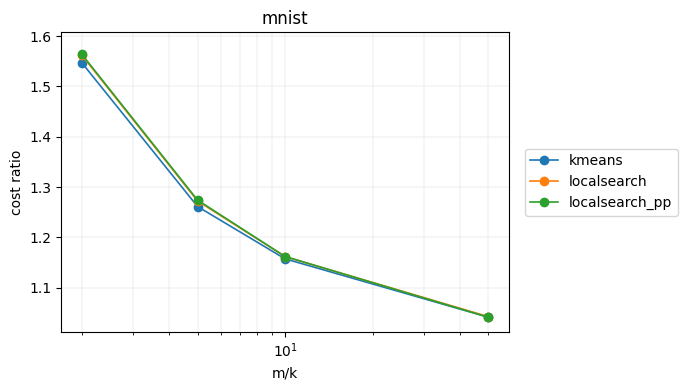

In [11]:
# ----- grid -----
k_list = [2, 5, 10, 50]
m_mults = [2, 5, 10, 50]     # m = mult * k
trials = list(range(10))          # 10 runs

# ----- algorithm knobs (changeable at the end) -----
algo_params = {
    "localsearch": {
        "iters": 30,
        "eval_n": 20000,
        "try_centers": "all"      # or 10 for speed
    },
    "localsearch_pp": {
        "extra_rounds": 50,       # theory-ish knob; tune later
        "eval_n": 20000,
        "try_centers": "all"      # or 10 for speed
    }
}

lloyd_iters = 10  # keep as-is

# ----- load full datasets -----

print("Loading MNIST...")
X_mnist = load_mnist_full(center=True)
print("MNIST:", X_mnist.shape)

# ----- run dataset-by-dataset (partial plots after each dataset) -----
for name, X in [("mnist", X_mnist)]:
    run_full_grid_for_dataset(name, X, k_list, m_mults, trials, algo_params, lloyd_iters=lloyd_iters)
    plot_dataset_m_over_k(RUNS_CSV, name)